# Image Provider 

In [1]:
import os
import sys

BASE_PATH = os.path.dirname(os.getcwd())
os.chdir(BASE_PATH)

In [2]:
from utils.datagenerator import TightFaceProvider
from utils.helper import show_images, cropper, glob_all_files, paths2numpy, mns
import numpy as np

# Train dataset

In [3]:
fg_folder = './data/wally_face_tight_crop/'
bg_folder = './data/block_imgs/'
tfp = TightFaceProvider(fg_folder, bg_folder, batch_size=128)

Max Height : 33 	 Min Height : 15
Max Width : 22 	 Min Width : 13
Max W/H Ratio : 1.0666666666666667 	 Min Ratio : 0.5862068965517241


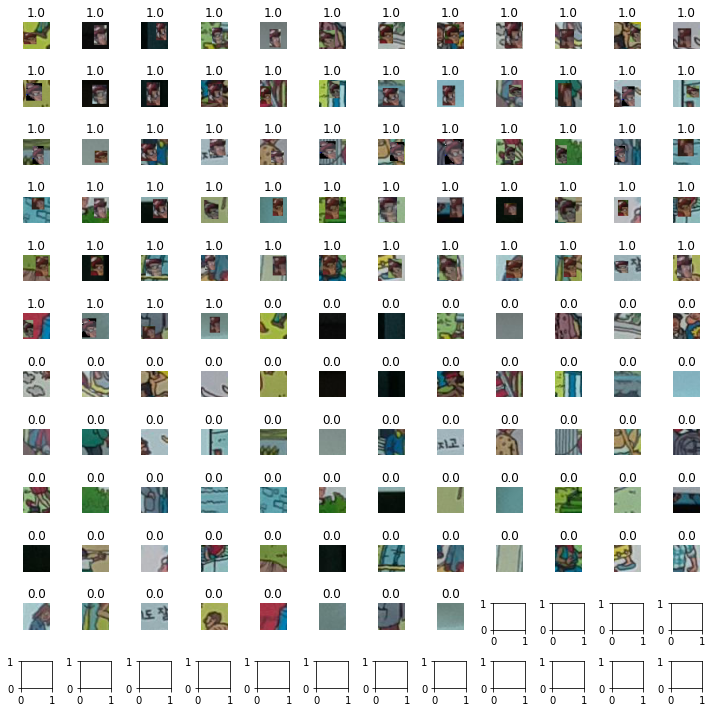

In [4]:
# 0번째 index의 batch 가져오기 
sample_imgs = tfp[0][0]
sample_labs = tfp[0][1]

# 이미지들이 pair 되었는지 확인합니다.  
show_images(sample_imgs, titles=sample_labs.tolist())

# Validation Dataset

In [5]:
# validation images 을 생성합니다. 
# 정답 좌표는 아직 생성하지 않았습니다. 
paths = glob_all_files('./data/full_images_val/')

crop_imgs = []
crop_crds = []
imgs = paths2numpy(paths)
for img in imgs:
    cropped_images, cropped_coords = cropper(img, 10, 10, 34, 34)
    crop_imgs.append(cropped_images)
    crop_crds.append(cropped_coords)

val_imgs = np.concatenate(crop_imgs, axis=0)
print(val_imgs.shape)

(97792, 34, 34, 3)


# Simple Conv

In [6]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, ReLU
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [7]:
K.clear_session()
inputs = Input(shape=(34, 34, 3), 
               name='inputs')

layer = inputs
# Convolution Layer
layer = Conv2D(filters=64, 
               kernel_size=3, 
               activation='relu')(layer)
layer = MaxPooling2D()(layer)

layer = Conv2D(filters=128, 
               kernel_size=3, 
               activation='relu')(layer)
layer = MaxPooling2D()(layer)

layer = Conv2D(filters=256, 
               kernel_size=3, 
               activation='relu')(layer)
layer = MaxPooling2D()(layer)

flat = Flatten()(layer)

# Fully Connected Layer
layer = flat
layer = Dense(units=256, activation='relu')(layer)
layer = Dense(units=256,activation='relu')(layer)

# Prediction
pred = Dense(1, activation='sigmoid')(layer)

# Model
model = Model(inputs, pred)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 34, 34, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 256)        

In [9]:
print(tfp[0][0].shape)
print(tfp[0][1].shape)

(128, 34, 34, 3)
(128,)


In [ ]:
# train 
for i in range(1):
    model.fit_generator(tfp, epochs=1)
    indices = (model.predict(val_imgs) > 0.5)[:, 0]
    show_images(val_imgs[indices])

Instructions for updating:
Please use Model.fit, which supports generators.
5179/5975 [=========================>....] - ETA: 1:41 - loss: 0.0305 - accuracy: 0.9953

In [ ]:
model.save('./models/best_model3')

# 전체 이미지에서 월리 찾아주기 

In [16]:
import matplotlib.pyplot as plt 
import cv2

for img_ind, im in enumerate(imgs):
    val_imgs = crop_imgs[img_ind]
    val_crds = crop_crds[img_ind]
    
    indices = (model.predict(val_imgs) > 0.5)[:, 0]
    target_imgs = val_imgs[indices]
    target_crds = np.array(val_crds)[indices]
    
    fig = plt.figure(figsize=(20,20))
    for coords in target_crds:
        print(coords)
        im = cv2.rectangle(im, tuple(coords[:2]), tuple(coords[2:]), (255, 0, 0), 3)
        im = mns(im, 0.6)
    plt.imshow(im)
    plt.show()


[1010  320 1044  354]


NameError: name 'mns' is not defined

<Figure size 1440x1440 with 0 Axes>